## OPERA

This dataset is obtained from the Optimizing Patient Experience and Response to Topical Analgesics (OPERA) study.



It consists in 631 patients with 50 survey questions. The objective is to investigate the effect of replacing opioid therapies with topical analgesics on patients with chronic pain and record the changes in multiple aspects of their life such as pain and medicine reduction, interference with everyday activities, and reduction of complaints. 


[Gudin JA, Brennan MJ, Harris ED et al.  Changes in pain and concurrent pain medication use following compounded topical analgesic treatment for chronic pain: 3- and 6-month follow-up results from the prospective, observational optimizing patient experience and response to topical analgesics study. J Pain Res 2017;10:2341–54.](https://www.tandfonline.com/doi/full/10.2147/JPR.S143513)


---

You can also see a state of the art utilization of this dataset in *MEvA-X: a hybrid multiobjective evolutionary tool using an XGBoost classifier for biomarkers discovery on biomedical datasets* (https://doi.org/10.1093/bioinformatics/btad384 and https://github.com/PanKonstantinos/MEvA-X).


In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import roc_auc_score

In [10]:
df = pd.read_csv("../data/OPERA.csv", index_col=[0,1])
df.index = df.index.droplevel(level=0)

df = df.transpose()
df.head()

Feature,Age,Gender,Least_24h,Average_pain,Current_pain,Overall_Pain_interference,Int_Gen_Activity,Int_Mood,Int_Walking_ability,Int_Work,...,Severity_Score,Tot_Compl_categ,TFFC1,TFFC2,TFFC3,TFFC4,BPISeverityChange,BPIInterferenceChange,ChangeGrandTotalMedicines,ChangeInTotalComplaintsNotIncludingOther
SM.1,0.396040,1.0,0.0,0.2,0.0,1.0,0.1,0.2,0.0,0.1,...,0.225,0.25,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0
SM.2,0.930733,1.0,0.7,0.7,1.0,0.7,0.9,0.7,0.9,0.9,...,0.850,0.25,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SM.3,0.517688,1.0,0.3,0.4,0.4,0.8,0.4,0.4,0.2,0.5,...,0.525,0.50,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
SM.4,0.606992,0.0,0.4,0.2,0.5,0.8,0.2,0.2,0.0,0.1,...,0.475,0.25,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SM.5,0.801118,0.0,0.1,0.2,0.0,0.0,0.5,0.5,0.5,0.5,...,0.175,0.25,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


This dataset has already been preprocessed with a KNN imputation and a min-max scaling normalizing each feature to the [0,1] range.


The dataset contains 50 features and 4 targets.

Here is a brief description:

Base demographics:
 * Age
 * Gender
 
Brief Pain Index ([example of form](https://www.npcrc.org/files/news/briefpain_short.pdf)):
 * Pain_other : 0/1 for presence of pain other than "usual" minor pains of daily life
 * Worst_24h
 * Least_24h
 * Average_pain
 * Current_pain
 * Severity_Score
 * Overall_Pain_interference
 * Avg_Interference
 * Int_Gen_Activity
 * Int_Mood
 * Int_Walking_ability
 * Int_Work
 * Int_Relationship
 * Int_Sleep
 * Int_Life_enjoyment
 
Complaint about different types of pain sources (*_bin*: 0/1 for presence of complaint ; *_categ* or *_cat*: number of complaints) :
 * Arthritis
 * NeuroRadic : neuropathy or radiculopathy pain
 * MyoMuscul :  myofascial or musculoskeletal pain
 * Tendinitis
 * Other
 * Pain_categ : number of pain categories with complaints
 * Tot_Compl_categ : same as above, but without other
 * Grand_Tot_Compl : total number of complaints (except other)

Which formulation of a topical pain medication was given to the patient (this can be considered the intervention of the study):
 * TFFC1
 * TFFC2
 * TFFC3
 * TFFC4

Additional Medication taken:
 * Meds_3days : 0/1 for medication taken in the last 3 days
 * Categ_of_meds : number of medication categories taken in the last 3 days
 * OTC : Over The Counter medications
 * AntiInflam : aintiinflammatory meds (also includes a total weight taken column)
 * Opioids_No_Anticonvulsants
 * Narcotic (also includes a total weight taken column)
 * Opioid_comb and Opioid_others : counts of different subsets of opioids 
 * Not_on_Anticonvulsant : 0/1 presence of anticonvulsant
 * Grand_Tot_Med : total number of medication taken


Finally, the different targets in this dataset are measured improvement between the baseline and the follow-up time:
 * BPISeverityChange : change in pain severity
 * BPIInterferenceChange : change in pain interference
 * ChangeGrandTotalMedicines : change in total medicine taken
 * ChangeInTotalComplaintsNotIncludingOther : change in number of complaints


In [28]:
targets = ['BPISeverityChange','BPIInterferenceChange', 
           'ChangeGrandTotalMedicines','ChangeInTotalComplaintsNotIncludingOther']

In [29]:
X = df.drop(columns=targets)
Y = df[targets]

## small EDA

In [37]:
for c in Y.columns:
    #sns.kdeplot( Y[c] )
    print("***")
    print(Y[c].value_counts())
    

***
BPISeverityChange
0.0    506
1.0    125
Name: count, dtype: int64
***
BPIInterferenceChange
0.0    523
1.0    108
Name: count, dtype: int64
***
ChangeGrandTotalMedicines
0.0    581
1.0     50
Name: count, dtype: int64
***
ChangeInTotalComplaintsNotIncludingOther
0.0    481
1.0    150
Name: count, dtype: int64


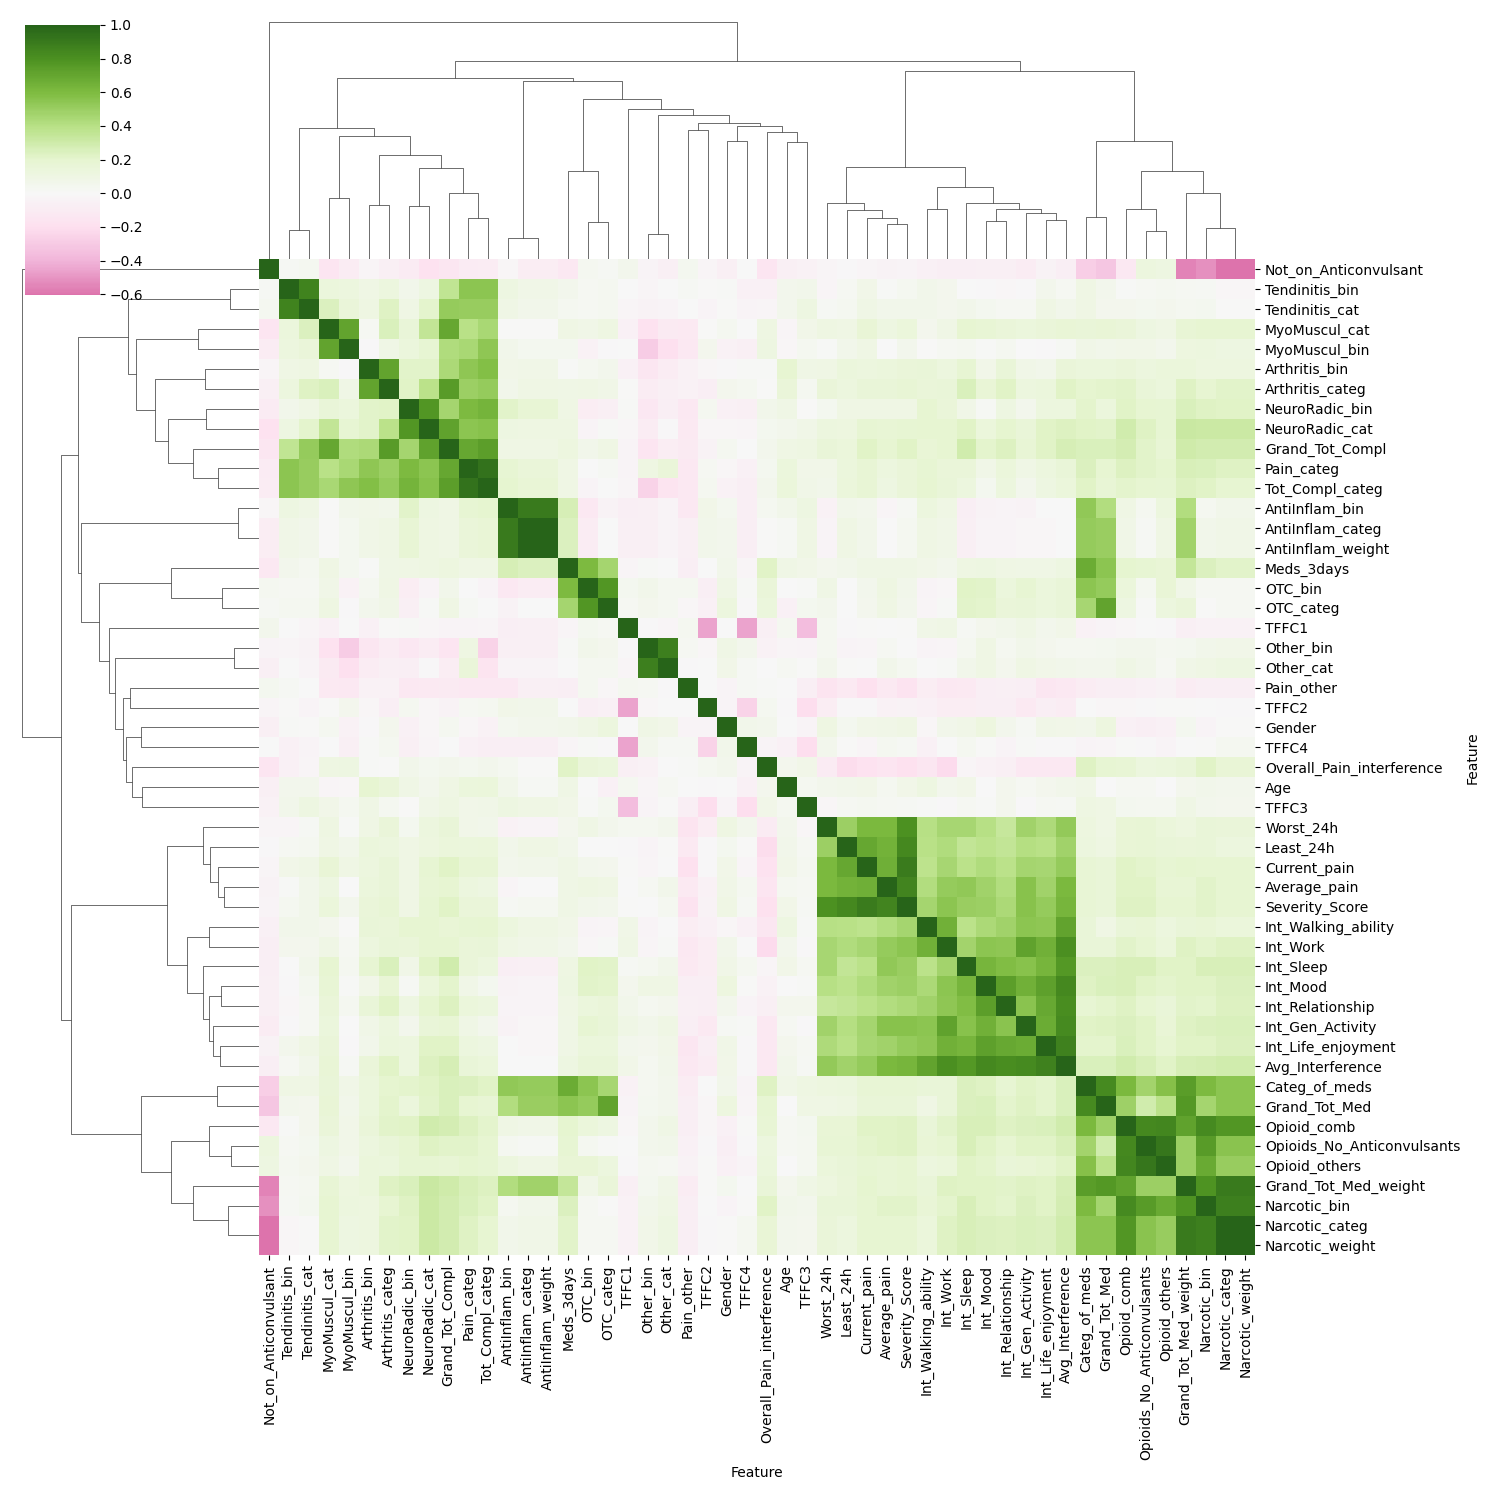

In [43]:
sns.clustermap( X.corr() ,
              figsize=(15, 15),
              cmap = "PiYG" , center = 0)

As we can see, a few columns are highly correlated (>0.9)

Text(0, 0.5, 'explained variance ratio')

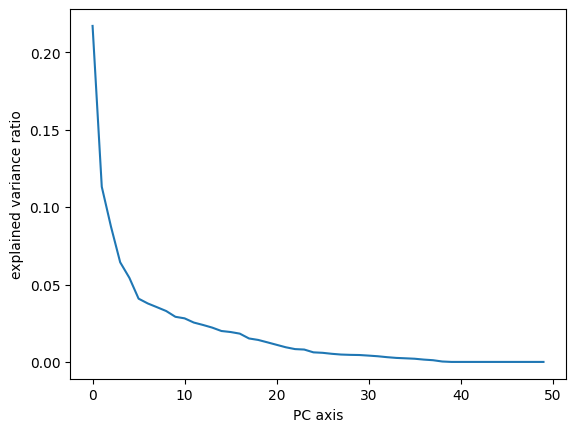

In [47]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
sc = StandardScaler()
pca = PCA()

x_pca = pca.fit_transform( sc.fit_transform(X) )


plt.plot( pca.explained_variance_ratio_ )
plt.xlabel("PC axis")
plt.ylabel("explained variance ratio")

<Axes: >

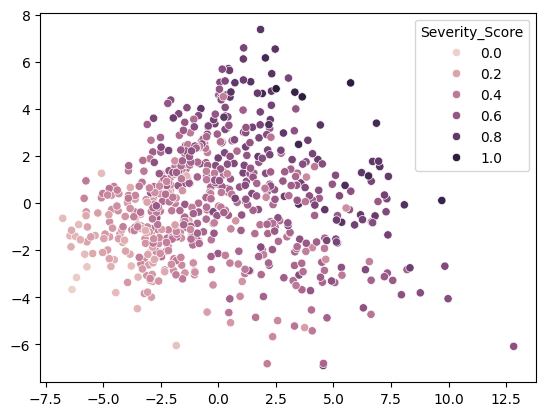

In [55]:
sns.scatterplot( x = x_pca[:,0] , y = x_pca[:,1] , hue = X.Severity_Score)

We encourage you to play with the plot above, color according to the different targets or columns, show different PC axes, ...


## your mission

Choose one of the target and train a classifier to predict it.

Try to see if you can gain some insight on the data by interpreting your model.

> Remember to respect ML best practices (train/test separation, cross-validation, use adapted metrics, ...)
